In [1]:
import os
import keras
import metrics
import numpy as np
import pandas as pd
import seaborn as sns

import keras.backend as K
import glob
from scipy.io import loadmat 
from IPython.display import display, clear_output

from time import time

from keras import callbacks
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_scatter_2D(data_2d, labels, centers):
    fig = plt.figure(1, figsize=(10,8))
    title = 'Ground-truth 2D view with '+str(len(set(labels)))+' clusters'
    ax  = fig.add_subplot(1, 1, 1)
    if labels is not None:
        axs = ax.scatter(data_2d[:,0], data_2d[:,1], c=labels, s=10)
    else:
        axs = ax.scatter(data_2d[:,0], data_2d[:,1], marker='*', s=10)
    if centers is not None:
        axs = ax.scatter(centers[:0], centers[:1], marker='X', c='red', s=100)
        title = '2D view - '+str(len(centers)) + ' clusters'
    fig.colorbar(axs)
    ax.set_xlabel('X'), ax.set_ylabel('Y')
    ax.dist = 10
    plt.title(title)
    plt.show()
    
def visualize_scatter_3D(data_3d, labels, centers):
    fig = plt.figure(1, figsize=(10,8))
    title = 'Ground-truth 3D view with '+str(len(set(labels)))+' clusters'
    ax  = fig.add_subplot(1, 1, 1, projection='3d')
    if labels is not None:
        axs = ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], c=labels, s=10)        
    else:
        axs = ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], marker='*', s=10)
    if centers is not None:
        axs = ax.scatter(centers[0], centers[1], centers[2], marker='X', c='red', s=100)
        title = '3D view - '+str(len(centers)) + ' clusters'
    fig.colorbar(axs)
    ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
    ax.dist = 10
    plt.title(title)
    plt.show()

In [3]:
file = 'area_3_data_pano_spherenet_VGG16_dims_512_256_16_8_batchNorm_no_relu_after_onlyConv_weights_added.mat'
data = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\"+file)
images = data["features"]
labels = data["labels"]
print(images.shape)
print(labels.shape)

(1530, 512)
(1, 1530)


In [4]:
# Assign ground truth labels
labels_gt = labels[0]
# Split dataset into train and test
x_train = images[:1230]
x_test  = images[-300:]
y_train = labels_gt[:1230]
y_test  = labels_gt[-300:]

In [5]:
set(labels_gt)

{0, 1, 2, 3, 4, 5, 6}

### KMeans Beasic Implementation

In [6]:
km = KMeans(n_jobs=-1, n_clusters = 7, n_init=20)

In [7]:
km.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [8]:
pred = km.predict(x_test)

In [9]:
set(pred)

{0, 1, 2, 3, 4, 6}

In [10]:
normalized_mutual_info_score(y_test, pred)

0.29603743034245616

### Autoencoder + KMeans

In [11]:
# this is our input placeholder
input_img = Input(shape=(512,))

# "encoded" is the encoded representation of the input
encoded = Dense(32, activation='relu')(input_img)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(20, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(512)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
__________

In [12]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [13]:
train_history = autoencoder.fit(x_train, x_train,
                                epochs=50,
                                batch_size=32,
                                shuffle=True,
                                validation_data=(x_test, x_test))

Train on 1230 samples, validate on 300 samples
Epoch 1/50
1230/1230 [==============================] - 0s 317us/step - loss: 219.5510 - val_loss: 366.9488
Epoch 2/50
1230/1230 [==============================] - 0s 102us/step - loss: 178.1359 - val_loss: 259.4491
Epoch 3/50
1230/1230 [==============================] - 0s 102us/step - loss: 104.2391 - val_loss: 169.2681
Epoch 4/50
1230/1230 [==============================] - 0s 102us/step - loss: 74.9808 - val_loss: 126.7454
Epoch 5/50
1230/1230 [==============================] - 0s 104us/step - loss: 68.2662 - val_loss: 112.3090
Epoch 6/50
1230/1230 [==============================] - 0s 103us/step - loss: 65.6371 - val_loss: 107.1951
Epoch 7/50
1230/1230 [==============================] - 0s 104us/step - loss: 64.9327 - val_loss: 105.8688
Epoch 8/50
1230/1230 [==============================] - 0s 94us/step - loss: 63.6931 - val_loss: 105.7076
Epoch 9/50
1230/1230 [==============================] - 0s 103us/step - loss: 61.8157 - val_los

In [14]:
pred_auto_train = encoder.predict(x_train)
pred_auto = encoder.predict(x_test)

In [15]:
km.fit(pred_auto_train)
pred = km.predict(pred_auto)

In [16]:
set(pred)

{0, 1, 2, 3, 4, 5, 6}

In [21]:
y_test.shape

(300,)

Score:  0.28155951158439657


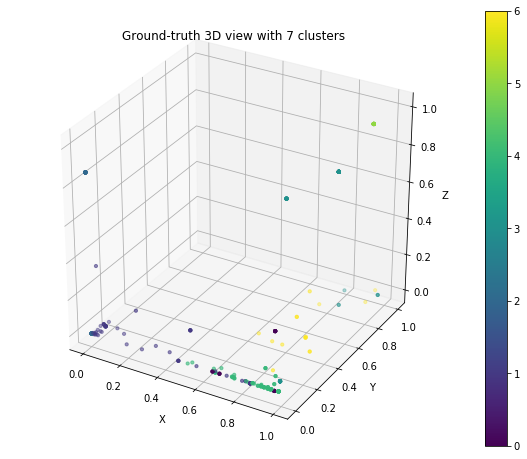

In [22]:
%matplotlib inline
print('Score: ',normalized_mutual_info_score(y_test, pred))
visualize_scatter_3D(pred_auto, labels=pred, centers=None)

### Deep Embedded Clustering (DEC) implementation

In [23]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

In [24]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=6))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=6,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred

In [26]:
import sys
sys.path.insert(0, 'Deep_Embedding_Clustering')
from main_notebooks_old.Deep_Embedding_Clustering import metrics

# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 32
maxiter = 2e4
tol = 0.001
save_dir = 'results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 50
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


# prepare the DEC model
dec = DEC(dims=[x_train.shape[-1], 32, 32, 128, 20], n_clusters=7, init=init)

dec.pretrain(x=x_train, y=y_train, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...
Epoch 1/50
1230/1230 [==============================] - 0s 325us/step - loss: 208.2651
        |==>  acc: 0.3423,  nmi: 0.1778  <==|
Epoch 2/50
1230/1230 [==============================] - 0s 89us/step - loss: 102.3913
Epoch 3/50
1230/1230 [==============================] - 0s 90us/step - loss: 63.9181
Epoch 4/50
1230/1230 [==============================] - 0s 102us/step - loss: 63.0130
Epoch 5/50
1230/1230 [==============================] - 0s 89us/step - loss: 62.1556
Epoch 6/50
1230/1230 [==============================] - 0s 102us/step - loss: 58.5007
        |==>  acc: 0.2919,  nmi: 0.1720  <==|
Epoch 7/50
1230/1230 [==============================] - 0s 89us/step - loss: 49.8592
Epoch 8/50
1230/1230 [==============================] - 0s 102us/step - loss: 45.3545
Epoch 9/50
1230/1230 [==============================] - 0s 102us/step - loss: 43.8222
Epoch 10/50
1230/1230 [==============================] - 0s 89us/step - loss: 41.8063
Epoch 11/50
1230/1230 [=========

In [27]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 32)                16416     
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                1056      
_________________________________________________________________
encoder_2 (Dense)            (None, 128)               4224      
_________________________________________________________________
encoder_3 (Dense)            (None, 20)                2580      
_________________________________________________________________
clustering (ClusteringLayer) (None, 7)                 140       
Total params: 24,416
Trainable params: 24,416
Non-trainable params: 0
_________________________________________________________________


In [28]:
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [29]:
y_pred = dec.fit(x_train, y=y_train, tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir=save_dir)

Update interval 200
Save interval 192.1875
Initializing cluster centers with k-means.
Iter 0: acc = 0.34309, nmi = 0.17840, ari = 0.08446  ; loss= 0
saving model to: results/DEC_model_0.h5
Iter 200: acc = 0.31301, nmi = 0.17209, ari = 0.05811  ; loss= 0
Iter 400: acc = 0.31138, nmi = 0.18503, ari = 0.04649  ; loss= 0
Iter 600: acc = 0.30163, nmi = 0.18208, ari = 0.04601  ; loss= 0
Iter 800: acc = 0.30894, nmi = 0.17369, ari = 0.05170  ; loss= 0
Iter 1000: acc = 0.32033, nmi = 0.17183, ari = 0.04982  ; loss= 0
Iter 1200: acc = 0.28455, nmi = 0.19248, ari = 0.06380  ; loss= 0
Iter 1400: acc = 0.30650, nmi = 0.19616, ari = 0.05233  ; loss= 0
Iter 1600: acc = 0.28293, nmi = 0.18124, ari = 0.04870  ; loss= 0
Iter 1800: acc = 0.33089, nmi = 0.18743, ari = 0.05697  ; loss= 0
Iter 2000: acc = 0.30163, nmi = 0.19004, ari = 0.06031  ; loss= 0
Iter 2200: acc = 0.28862, nmi = 0.18554, ari = 0.05139  ; loss= 0
Iter 2400: acc = 0.29268, nmi = 0.18391, ari = 0.05154  ; loss= 0
Iter 2600: acc = 0.2951

In [30]:
pred_val = dec.predict(x_test)

In [31]:
set(pred_val)

{0, 1, 2, 3, 4, 5, 6}

In [32]:
normalized_mutual_info_score(y_test, pred_val)

0.3444378344533962

Score:  0.3444378344533962


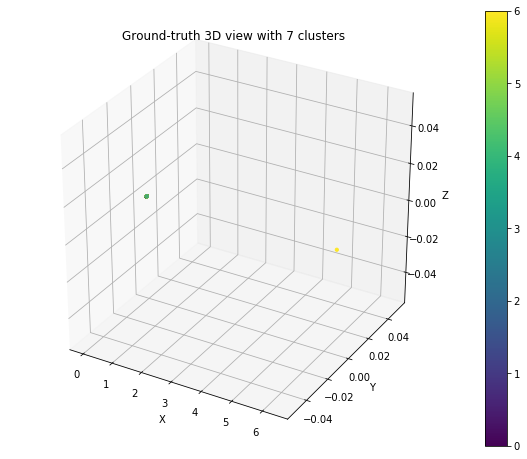

In [33]:
%matplotlib inline
print('Score: ',normalized_mutual_info_score(y_test, pred_val))
visualize_scatter_3D(x_test, labels=pred_val, centers=None)

In [34]:
x_test.shape

(300, 512)